# Testing an AR(1) Noise Model for Pastas
*R.A. Collenteur, University of Graz, May 2020*

In this notebook the classical Autoregressive AR(1) noise model is tested for Pastas models. This noise model is tested against synthetic data generated with NumPy or Statsmodels' ARMA model. This noise model is tested on head time series with regular and irregular time steps.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pastas as ps

ps.set_log_level("ERROR")
ps.show_versions()

Python version: 3.9.7
NumPy version: 1.24.3
Pandas version: 1.5.3
SciPy version: 1.10.1
Matplotlib version: 3.7.0
Numba version: 0.57.0
LMfit version: 1.0.3
Latexify version: 0.2.0
Pastas version: 1.1.0


## 1. Develop the AR(1) Noise Model for Pastas

The following formula is used to calculate the noise according to the ARMA(1,1) process:

$$\upsilon(t_i) = r(t_i) - r(t_{i-1}) \text{e}^{-\Delta t_i / \alpha}$$

where $\upsilon$ is the noise, $\Delta t_i$ the time step between the residuals ($r$), and $\alpha$ [days] the AR parameter of the model. The model is named `NoiseModel` and can be found in `noisemodel.py`. This is the default noise model that is added to a Pastas model, but it can also be added manually as follows: `ml.add_noisemodel(ps.NoiseModel())`

## 2. Generate synthetic head time series

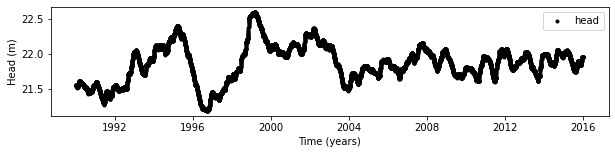

In [2]:
# Read in some data
rain = (
    pd.read_csv("../examples/data/rain_260.csv", index_col=0, parse_dates=[0]).squeeze()
    / 1000
)

# Set the True parameters
Atrue = 800
ntrue = 1.4
atrue = 200
dtrue = 20

# Generate the head
step = ps.Gamma().block([Atrue, ntrue, atrue], cutoff=0.9999)
h = dtrue * np.ones(len(rain) + step.size)
for i in range(len(rain)):
    h[i : i + step.size] += rain[i] * step
head = pd.DataFrame(
    index=rain.index,
    data=h[: len(rain)],
)
head = head["1990":"2015"]

# Plot the head without noise
plt.figure(figsize=(10, 2))
plt.plot(head, "k.", label="head")
plt.legend(loc=0)
plt.ylabel("Head (m)")
plt.xlabel("Time (years)");

## 3. Generate AR(1) noise and add it to the synthetic heads
In the following code-block, noise is generated using an AR(1) process using Numpy.

In [3]:
# reproduction of random numbers
np.random.seed(1234)
alpha = 0.8

# generate samples using NumPy
random_seed = np.random.RandomState(1234)
noise = random_seed.normal(0, 1, len(head)) * np.std(head.values) * 0.2
a = np.zeros_like(head[0])

for i in range(1, noise.size):
    a[i] = noise[i] + a[i - 1] * alpha

head_noise = head[0] + a

## 4. Create and solve a Pastas Model

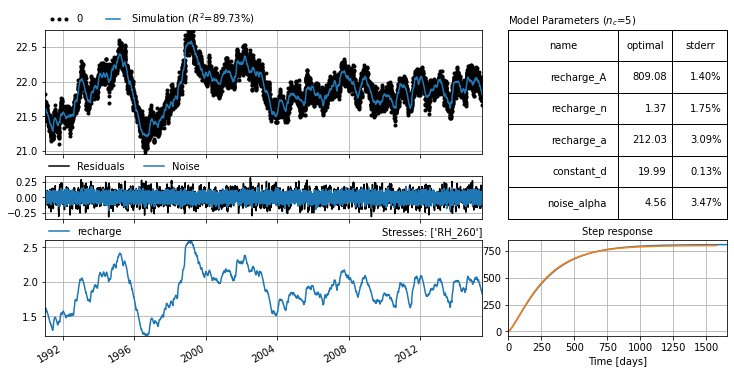

In [4]:
ml = ps.Model(head_noise)
sm = ps.StressModel(rain, ps.Gamma(), name="recharge", settings="prec")
ml.add_stressmodel(sm)
ml.add_noisemodel(ps.NoiseModel())

ml.solve(tmin="1991", tmax="2015-06-29", noise=True, report=False)

# Plot the results
axes = ml.plots.results(figsize=(10, 5))
axes[-2].plot(ps.Gamma().step([Atrue, ntrue, atrue], cutoff=0.999));

## 5. Did we find back the original AR parameter?

In [5]:
print(np.exp(-1.0 / ml.parameters.loc["noise_alpha", "optimal"]).round(2), "vs", alpha)

0.8 vs 0.8


The estimated parameters for the noise model are almost the same as the true parameters, showing that the model works for regular time steps.

## 6. So is the autocorrelation removed correctly?

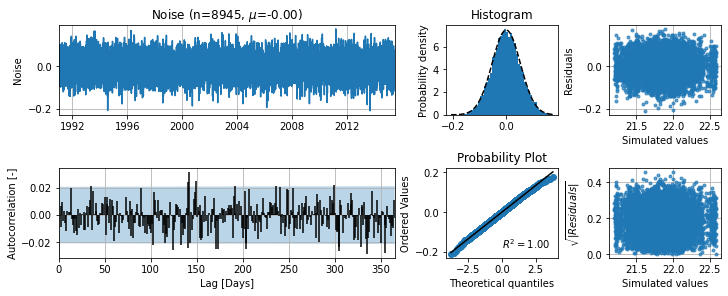

In [6]:
ml.plots.diagnostics(figsize=(10, 4));

That seems okay. It is important to understand that this noisemodel will only help in removing autocorrelations at the first time lag, but not at larger time lags.

## 7. Test the NoiseModel for irregular time steps
In this final step the Ar(1) noisemodel is tested for irregular timesteps, using the indices from a real groundwater level time series.

In [7]:
index = (
    pd.read_csv("../examples/data/test_index.csv", parse_dates=True, index_col=0)
    .index.round("D")
    .drop_duplicates()
)
head_irregular = head_noise.reindex(index)

0.78 vs 0.8


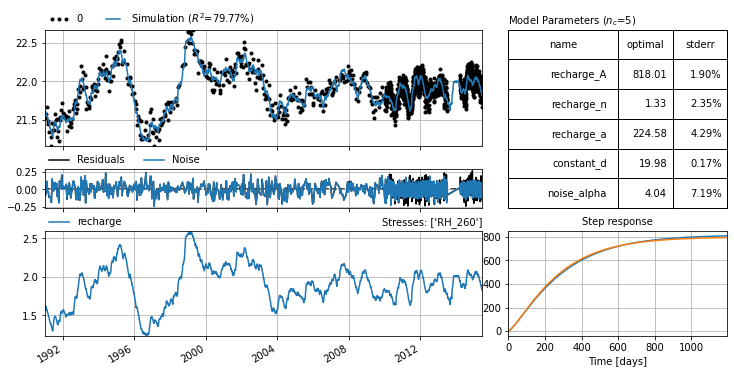

In [8]:
ml = ps.Model(head_irregular)
sm = ps.StressModel(rain, ps.Gamma(cutoff=0.99), name="recharge", settings="prec")
ml.add_stressmodel(sm)
ml.add_noisemodel(ps.NoiseModel())

# ml.set_parameter("noise_alpha", 9.5, vary=False)
# ml.set_parameter("recharge_A", 800, vary=False)
# ml.set_parameter("recharge_n", 1.2, vary=False)
# ml.set_parameter("recharge_a", 200, vary=False)

ml.solve(tmin="1991", tmax="2015-06-29", noise=True, report=False)
axes = ml.plots.results(figsize=(10, 5))
axes[-2].plot(ps.Gamma().step([Atrue, ntrue, atrue]))

print(np.exp(-1.0 / ml.parameters.loc["noise_alpha", "optimal"]).round(2), "vs", alpha)

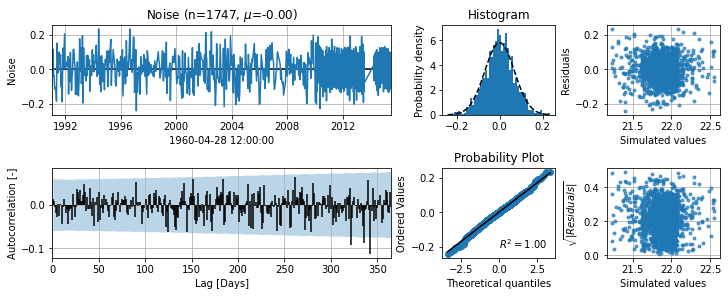

In [9]:
ml.plots.diagnostics(figsize=(10, 4), acf_options={"bin_width": 0.5});

This autocorrelation plot looks good too.

In [10]:
v = ml.noise()
print("", v.loc[:"2010-01-01"].std())
print("", v.loc["2010-01-01":].std())

 0.08935768738592514
 0.060537546555873414
